# Inverse problems in Geosciences  
Geosciences as a field are a prime example for inverse problems. A lot of problems in geosciences are ill-posed, fundamentally due to the lack of observation data. As direct observations in the subsurface are limited to trenches, pits (not really deep) and boreholes (one dimensional), the majority of the subsurface has to be explored via indirect methods.  
However, also data from indirect observation methods do not solve a fundamental problem in geosciences:  
<center>*Although being totally deterministic, uncertainty remains as we cannot observe the whole system.*</center>  
The deepest direct observation we have is the [Kola Superdeep Borehole](https://en.wikipedia.org/wiki/Kola_Superdeep_Borehole) with a final depth of 12,262 metres below the ground level. While still the deepest borehole, it is not the longest borehole worldwide anymore, as progress in (sub-)horizontal drilling technique facilitated the construction in long horizontal boreholes.  

However, having drilled 12 km in the Earth means that we penetrated 0.19 % of the Earth's radius, i.e. the distance to the center. To put that into perspective, if Earth was an average apple (with a diameter of 70 mm), we would not even have drilled through its skin (which has an average thickness of 0.3 mm)!  

So how do scientists know the internal structure of the Earth? By using indirect observation techniques, in this case waves triggered by Earthquakes (let's call them EQ-waves). In this field of science called seismology, the location of an Earthquake is important to know. However, seismographs (the measuring devices) only register the magnitude, direction and time of arriving EQ-waves. For estimating the location of the origin of the earthquake, the __hypocenter__ (whose lateral position projected to the Earth's surface is called __epicenter__) we need to solve an __inverse problem__.

In this notebook, we go through the process of locating a epicenter of an earthquake by using the least squares method. This is a very basic optimization, i.e. fitting algorithm (fitting a line to a bunch of observation points is an inverse process itself). The following data can code are from the course "_Inverse problems_" I heard at the Rennes 1 University in Brittany, France.  


Arrival time formulation _explain in more detail_  

$$F_i(m) = t_{obs} = t_0 + \frac{1}{v_p} \times [(x_i - x_0)^2 + (y_i - y_0)^2 + z_0^2]^{0.5} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# let's load the data
coord = np.genfromtxt('loctim.txt')
border = np.genfromtxt('border.xy')

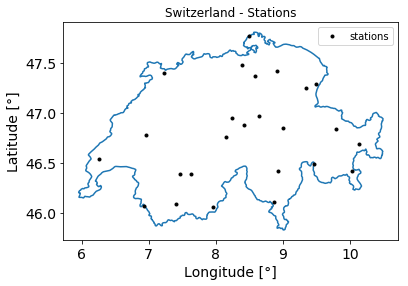

In [15]:
plt.plot(border[:,0],border[:,1])
plt.plot(coord[:,0], coord[:,1], 'k.', label='stations')
plt.xlabel('Longitude [°]', fontsize=14)
plt.ylabel('Latitude [°]', fontsize=14)
plt.title('Switzerland - Stations')
plt.tick_params(axis='both', labelsize=14)
plt.legend()